In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
import json
import scipy.stats as stats
import math

import category_encoders as ce

import statsmodels.api as sm
import statsmodels.stats as sm_stats
import statsmodels.stats.api as sms

import vizualizacia_funkcie as visual

from sklearn import preprocessing
from sklearn import pipeline
from sklearn import base
from sklearn import compose
from sklearn import feature_selection
from sklearn import model_selection

from datetime import datetime
from datetime import date

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc

import imblearn
import preprocessing_pipeline as prep_pip

# grafy
from sklearn.tree import export_graphviz
from graphviz import Source
from IPython.display import SVG
from IPython.display import HTML # toto je tu len pre to aby sa mi obrazok zmestil na obrazovku


# Predspracovanie validacneho datasetu a opis pripadnych zmien

In [2]:
df1 = pd.read_csv("./data/personal_train.csv", index_col=0)
df2 = pd.read_csv("./data/other_train.csv", index_col=0)

X, y = prep_pip.one_proper_df(df1, df2)

C:\Users\makoh\IAU\git_projekt\IAU\preprocessing_pipeline.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_dataset.iloc[0][attr] = not_null.values[0]


In [3]:
PIP = prep_pip.get_preprocessing_pipeline()

In [4]:
X_train, y_train = PIP.fit_predict(X, y)

In [5]:
print(X_train.shape)
print(y_train.shape)

(3254, 33)
(3254,)


In [6]:
X_train.columns

Index(['age', 'mean_oxygen', 'std_oxygen', 'kurtosis_oxygen',
       'skewness_oxygen', 'mean_glucose', 'std_glucose', 'kurtosis_glucose',
       'skewness_glucose', 'sex_0', 'sex_1', 'marital-status_0',
       'marital-status_1', 'marital-status_2', 'marital-status_3',
       'relationship_0', 'relationship_1', 'relationship_2', 'relationship_3',
       'occupation_0', 'occupation_1', 'occupation_2', 'occupation_3',
       'occupation_4', 'occupation_5', 'occupation_6', 'occupation_7',
       'occupation_8', 'workclass_0', 'workclass_1', 'education',
       'hours-per-week-cat', 'income'],
      dtype='object')

# Pri praci s validacnym datasetom sa nepouziva fit_predict ale iba predict

In [7]:
df1 = pd.read_csv("./data/personal_valid.csv", index_col=0)
df2 = pd.read_csv("./data/other_valid.csv", index_col=0)

X, y = prep_pip.one_proper_df(df1, df2)

data = X
data["class"] = y


indices = data.loc[data["class"].isnull()].index.values

data = data.drop(index=indices)
data = data.reset_index(drop=True)

X = data.drop(columns=["class"])
y = data["class"]

C:\Users\makoh\IAU\git_projekt\IAU\preprocessing_pipeline.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_dataset.iloc[0][attr] = not_null.values[0]


In [8]:
X_valid = PIP.predict(X)
y_valid = y

In [9]:
print(X_valid.shape)
print(y_valid.shape)

(1303, 33)
(1303,)


# Manualne vytvorenie a vyhodnotenie rozhodovacich pravidiel pre klasifikaciu

# NAJDI 4 atributy s najvacsiou korelaciou medzi nimi a classou 
# hladaj iba mezdi tymito 8 medical atributmi

In [10]:
# medical_attributes = ['kurtosis_glucose', 'skewness_glucose', 'mean_glucose', 'std_glucose', 
#                       'kurtosis_oxygen','skewness_oxygen', 'mean_oxygen', 'std_oxygen']

medical_attributes = ["kurtosis_glucose", "skewness_glucose", "mean_glucose", "std_glucose"]

medical_train_ds = X_train[medical_attributes]
medical_train_ds['class'] = y_train

C:\Users\makoh\anaconda3\envs\IAU\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [11]:
medical_valid_ds = X_valid[medical_attributes]
medical_valid_ds['class'] = y_valid

C:\Users\makoh\anaconda3\envs\IAU\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


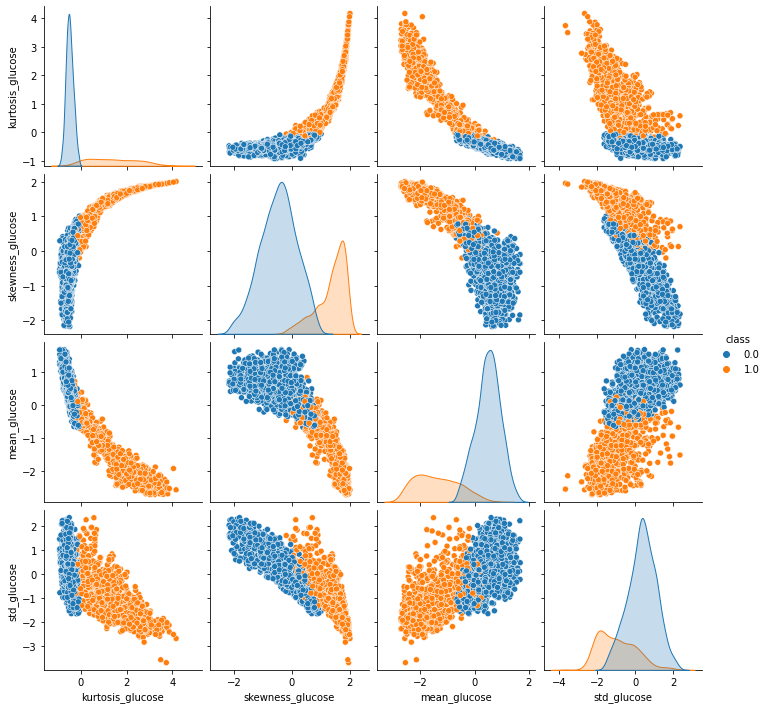

In [12]:
sns.pairplot(medical_train_ds[['kurtosis_glucose', 'skewness_glucose', 'mean_glucose', 'std_glucose','class']], hue = 'class')

Korelacia medzi nasim atributom a y: 0.8332636111101277


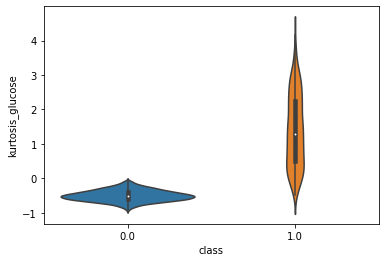

C:\Users\makoh\anaconda3\envs\IAU\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\makoh\anaconda3\envs\IAU\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


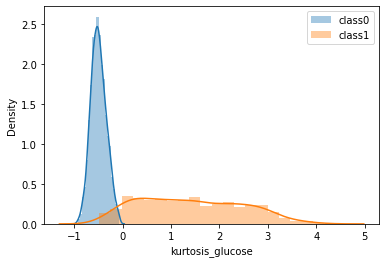

In [13]:
visual.univariate_num_to_class(medical_train_ds, "kurtosis_glucose", show_regplot=False)

Korelacia medzi nasim atributom a y: 0.8027704566351079


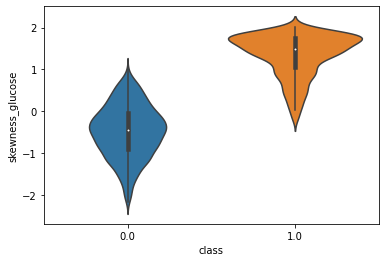

C:\Users\makoh\anaconda3\envs\IAU\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\makoh\anaconda3\envs\IAU\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


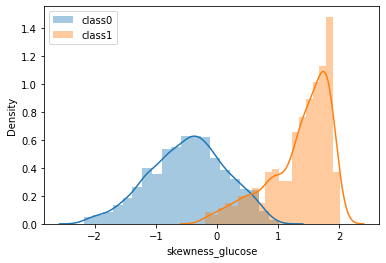

In [14]:
visual.univariate_num_to_class(medical_train_ds, "skewness_glucose", show_regplot=False)

Korelacia medzi nasim atributom a y: -0.8281683196822146


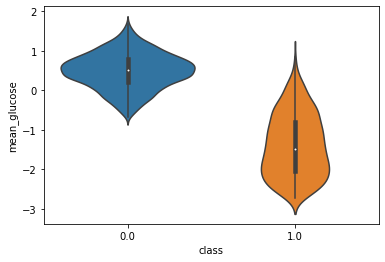

C:\Users\makoh\anaconda3\envs\IAU\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\makoh\anaconda3\envs\IAU\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


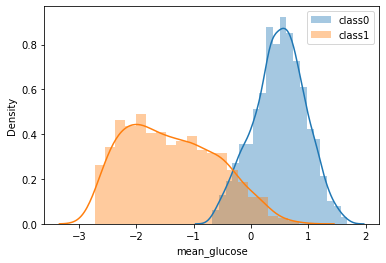

In [15]:
visual.univariate_num_to_class(medical_train_ds, "mean_glucose", show_regplot=False)

Korelacia medzi nasim atributom a y: -0.5792708486920812


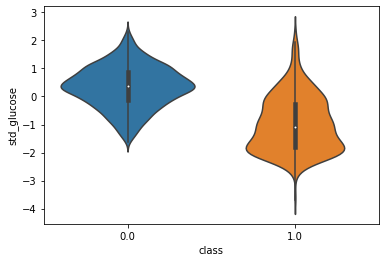

C:\Users\makoh\anaconda3\envs\IAU\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\makoh\anaconda3\envs\IAU\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


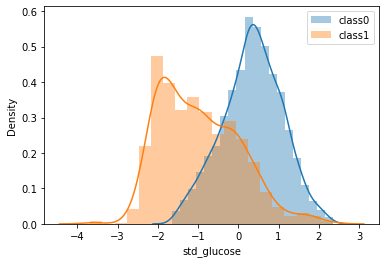

In [16]:
visual.univariate_num_to_class(medical_train_ds, "std_glucose", show_regplot=False)

# Nami vytvoreny strom

In [17]:
class Node:
    
    #budeme sa riadit, ze pravidla vyzeraju ATTR < X, kedy pokial je to pravda, ideme dolava
    def __init__(self, threshold=None, col_name=None, gini=None, leaf=True, root=False):
        
        self.root = root
    
        self.left = None
        self.right = None

        #atributy inner nodu
        self.col_name = col_name
        self.threshold = threshold
        
        
        
        #atributy leaf nodu
        self.predicition = None
        self.leaf = leaf
        self.gini = gini
    


In [18]:
#v nasom strome budeme pracovat len s ciselnymi atributmi
class DecisionTree:
    
    def __init__(self):
        self.root = Node(leaf=False, root=True)
        
    def fit(self, X, y, node=None):
        
        #uz nemame dataset
        if X.shape[1] == 0 or X.shape[0] == 0:
            return
        
        #pokial dany node ma gini impurity == 0, tak cely dataset ma rovnaku triedu
        if node is not None and node.gini == 0:
            return
        
        #hladanie optimalneho thresholdu
        attribute_name, threshold = self.best_threshold(X, y)
        
        #pokial najlepsi threshold je stale vacsi ako doterajsia impurita - teda sa neoplati uz dataset
        #splitovat, a teda koncime
        if node is not None and node.gini < threshold:
            return
        
        #splitneme dataset podla pravidla + vypocitame gini impurity pre konkretne children nody
        data = X
        data["class"] = y
        
        left_data = data.loc[data[attribute_name] < threshold]
        right_data = data.loc[data[attribute_name] >= threshold]
        
        #taktiez dropneme atribut, ktoremu sme uz vytvorili pravidlo
        left_data = left_data.drop(columns=[attribute_name])
        right_data = right_data.drop(columns=[attribute_name])
        
        #vypocitame gini impurity pre jednotlive children nody
        left_yes = len(left_data.loc[data["class"] == 1])
        left_no = len(left_data.loc[data["class"] == 0])
        
        right_yes = len(right_data.loc[data["class"] == 1])
        right_no = len(right_data.loc[data["class"] == 0])
        
        left_gini = 1 - (left_yes/len(left_data))**2 - (left_no/len(left_data))**2
        right_gini = 1 - (right_yes/len(right_data))**2 - (right_no/len(right_data))**2
        
    
        #chceme vypocitat, co children nody klasifikuju, pokial by zostali leaf nodami
        left_pred = 0
        right_pred = 0
        
        if left_yes >= left_no:
            left_pred = 1
        
        if right_yes >= right_no:
            right_pred = 1
         
        
        if node is None:
            node = self.root
            
        #pridanie atributov pre inner node - pravidlo
        node.threshold = threshold
        node.col_name = attribute_name
        node.leaf = False
        
        #vytvorime children nody
        node.left = Node()
        node.right = Node()
        
        #pridanie atributov pre leaf nody
        node.left.prediction = left_pred
        node.left.gini = left_gini
        
        node.right.prediction = right_pred
        node.right.gini = right_gini
    
            
        #rekurzivne vytvarame dalsie nody v strome
        
        #lavy podstrom
        self.fit(left_data.drop(columns=["class"]), left_data["class"], node.left)
        
        #pravy podstrom
        self.fit(right_data.drop(columns=["class"]), right_data["class"], node.right)
        
    
    def best_threshold(self, X, y):
        
        n_features = X.shape[1]
        col_names = X.columns.values
        
        print("hladanie najlepsich thresholdov s poctom atributov:", n_features)
        
        best_thresholds = np.zeros(n_features)
        
        best_ginis = np.ones(n_features)
        
        #hladame najlepsi threshold v kazdom atribute
        for i in range(n_features):
            
            print("ity feature:", i)
            
            data = X.copy()
            data["class"] = y.copy()
            
            data = data.sort_values(by=[col_names[i]], ascending=True)
            
            #hladame najlepsi threshold pre konkretny atribut
            for row in range(len(data)-1):
                
                thresh = (data.iloc[row][col_names[i]] + data.iloc[row+1][col_names[i]]) / 2
                impurity = self.get_gini(X, y, thresh, col_names[i])
                
                if impurity < best_ginis[i]:
                    best_thresholds[i] = thresh
                    best_ginis[i] = impurity
        
        #teraz vratime najlepsi threshold s najlepsich, spolu s nazvom stplca
        index = np.argmin(best_ginis)
        print("GINI:", best_ginis[index])
        return col_names[index], best_thresholds[index]
    
    def predict(self, X):
        predictions = np.zeros(len(X))
        
        for i in range(len(X)):
            predictions[i] = self.traverse_tree(X.iloc[i])
            
        return predictions
        
    
    def traverse_tree(self, x):
        node = self.root
        
        while node.leaf == False:
            col = node.col_name
            if x[col] < node.threshold:
                node = node.left
            else:
                node = node.right
        
        return node.prediction
    
    #vracia a zaroven vypisuje metriky v poradi accuracy, precision, recall, f1
    def score(self, valid_data):
        
        truth = valid_data["class"].values
        predictions = self.predict(valid_data.drop(columns=["class"]))
        
        TP = ((truth == 1) & (predictions == 1)).sum()
        FP = ((truth == 0) & (predictions == 1)).sum()
        TN = ((truth == 0) & (predictions == 0)).sum()
        FN = ((truth == 1) & (predictions == 0)).sum()
        
        accuracy = (TP+TN)/(len(truth))#+1e-9)
        precision = TP/(TP+FP)#+1e-9)
        recall = TP/(TP+FN)#+1e-9)
        f1 = 2 * (precision*recall) / (precision+recall)
        
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1 score:", f1)
        
        return accuracy, precision, recall, f1
    
    def get_gini(self, X, y, thresh, col):
        
        data = X
        data["class"] = y
        
        left_data = data.loc[data[col] < thresh]
        right_data = data.loc[data[col] >= thresh]
        
        #neoplati sa nam splitovat dataset, pokial cely dataset sa presunie do ineho nodu, takze
        #automaticky dame gini = 2, aby sme nevybrali tento threshold
        if len(left_data) == 0 or len(right_data) == 0:
            return 2
        
        left_yes = len(left_data.loc[data["class"] == 1])
        left_no = len(left_data.loc[data["class"] == 0])
        
        right_yes = len(right_data.loc[data["class"] == 1])
        right_no = len(right_data.loc[data["class"] == 0])
        
        left_gini = 1 - (left_yes/len(left_data))**2 - (left_no/len(left_data))**2
        right_gini = 1 - (right_yes/len(right_data))**2 - (right_no/len(right_data))**2
        
        gini = (len(left_data) / len(X))*left_gini + (len(right_data)/len(X))*right_gini
        return gini
        

In [19]:
import warnings
warnings.filterwarnings('ignore')

import time

tree = DecisionTree()
tree.fit(medical_train_ds.drop(columns=["class"]), medical_train_ds["class"])

hladanie najlepsich thresholdov s poctom atributov: 4
ity feature: 0
ity feature: 1
ity feature: 2
ity feature: 3
GINI: 0.03246076807014266
hladanie najlepsich thresholdov s poctom atributov: 3
ity feature: 0
ity feature: 1
ity feature: 2
GINI: 0.041223446347144595
hladanie najlepsich thresholdov s poctom atributov: 2
ity feature: 0
ity feature: 1
GINI: 0.11097497998303893


In [20]:
tree.score(medical_valid_ds)

Accuracy: 0.953184957789716
Precision: 0.9246987951807228
Recall: 0.8950437317784257
F1 score: 0.9096296296296296


(0.953184957789716, 0.9246987951807228, 0.8950437317784257, 0.9096296296296296)

# Natrenovanie a vyhodnotenie klasifikatora s vyuzitim rozhodovacich stromov

In [21]:
print(X_train.shape)
print(y_train.shape)

(3254, 33)
(3254,)


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)

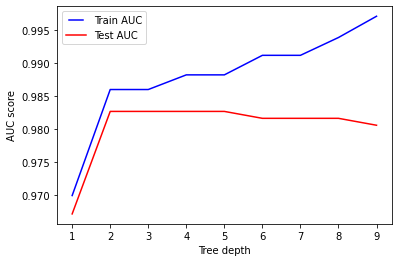

In [23]:
max_depths = np.linspace(1, 9, 9, endpoint=True)

train_results = []
test_results = []

for max_depth in max_depths:
    dt = DecisionTreeClassifier(max_depth=max_depth)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous train results
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # Add auc score to previous test results
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_depths, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()

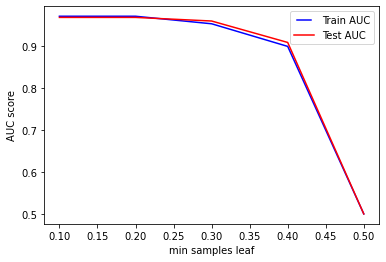

In [24]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
for min_samples_leaf in min_samples_leafs:
    dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    dt.fit(X_train, y_train)
    train_pred = dt.predict(X_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = dt.predict(X_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, 'b', label='Train AUC')
line2, = plt.plot(min_samples_leafs, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('min samples leaf')
plt.show()

In [25]:
def printMetrics(model):
    print('---------------------ACCURACY-----------------------')
    
    y_pred = model.predict(X_valid)
    print('Accuracy: ', accuracy_score(y_valid, y_pred))
    
    print('---------------------PRECISION----------------------')
    
    micro_precision = precision_score(y_pred, y_valid, average='micro')
    print('Micro-averaged precision: ', micro_precision)

    macro_precision = precision_score(y_pred, y_valid, average='macro')
    print('Macro-averaged precision: ', macro_precision)

    per_class_precision = precision_score(y_pred, y_valid, average=None)
    print('Per-class precision score:', per_class_precision)
    
    print('----------------------RECALL------------------------')
    
    micro_recall = recall_score(y_valid, y_pred, average='micro')
    print('Micro-averaged recall: ', micro_recall)

    macro_recall = recall_score(y_valid, y_pred, average='macro')
    print('Macro-averaged recall: ', macro_recall)

    per_class_recall = recall_score(y_valid, y_pred, average=None)
    print('Per-class recall score:', per_class_recall)
    
    print('----------------------F1-SCORE----------------------')
    
    micro_f1_score = f1_score(y_valid, y_pred, average='micro')
    print('Micro-averaged f1 score: ', micro_f1_score)

    macro_f1_score = f1_score(y_valid, y_pred, average='macro')
    print('Macro-averaged f1 score: ', macro_f1_score)

    per_class_f1_score = f1_score(y_valid, y_pred, average=None)
    print('Per-class f1 score:', per_class_f1_score)

In [26]:
def visualizeTree(model, X):
    graph = Source(export_graphviz(model, 
                               out_file=None,
                               feature_names=X.columns,
                               class_names=['no', 'yes'],
                               filled = True))

    display(SVG(graph.pipe(format='svg')))

    style = "<style>svg{width:70% !important;height:70% !important;}</style>"
    HTML(style)

In [27]:
def testDecissionTree(criterion, max_depth, min_samples_leaf, max_features, max_leaf_nodes, random_state, splitter, X, y):
    dt = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, min_samples_leaf = min_samples_leaf, 
                               max_features = max_features, max_leaf_nodes = max_leaf_nodes, random_state = random_state,
                               splitter = splitter)
    
    dt.fit(X, y)
    
    print('---------------------PARAMETERS---------------------')
    
    print(dt)
    
    printMetrics(dt)
    
    visualizeTree(dt, X)

---------------------PARAMETERS---------------------
DecisionTreeClassifier(max_depth=2,
                       random_state=<module 'numpy.random' from 'C:\\Users\\makoh\\anaconda3\\envs\\IAU\\lib\\site-packages\\numpy\\random\\__init__.py'>)
---------------------ACCURACY-----------------------
Accuracy:  0.884113584036838
---------------------PRECISION----------------------
Micro-averaged precision:  0.884113584036838
Macro-averaged precision:  0.8998056365403304
Per-class precision score: [0.86666667 0.93294461]
----------------------RECALL------------------------
Micro-averaged recall:  0.884113584036838
Macro-averaged recall:  0.8998056365403304
Per-class recall score: [0.86666667 0.93294461]
----------------------F1-SCORE----------------------
Micro-averaged f1 score:  0.884113584036838
Macro-averaged f1 score:  0.8629534048681273
Per-class f1 score: [0.91680441 0.8091024 ]


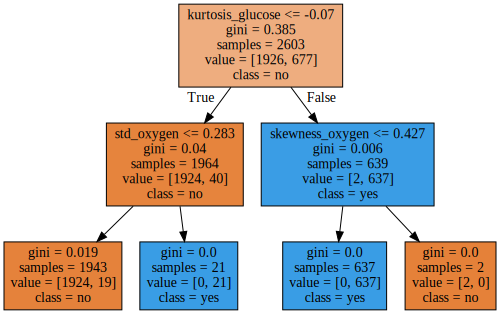

In [28]:
testDecissionTree('gini', 2, 1, None, None, np.random, 'best', X_train, y_train)

---------------------PARAMETERS---------------------
DecisionTreeClassifier(max_depth=8,
                       random_state=<module 'numpy.random' from 'C:\\Users\\makoh\\anaconda3\\envs\\IAU\\lib\\site-packages\\numpy\\random\\__init__.py'>)
---------------------ACCURACY-----------------------
Accuracy:  0.8795088257866462
---------------------PRECISION----------------------
Micro-averaged precision:  0.8795088257866462
Macro-averaged precision:  0.8948068513119534
Per-class precision score: [0.8625    0.9271137]
----------------------RECALL------------------------
Micro-averaged recall:  0.8795088257866462
Macro-averaged recall:  0.8948068513119534
Per-class recall score: [0.8625    0.9271137]
----------------------F1-SCORE----------------------
Micro-averaged f1 score:  0.8795088257866462
Macro-averaged f1 score:  0.8577104267970779
Per-class f1 score: [0.9134032  0.80201765]


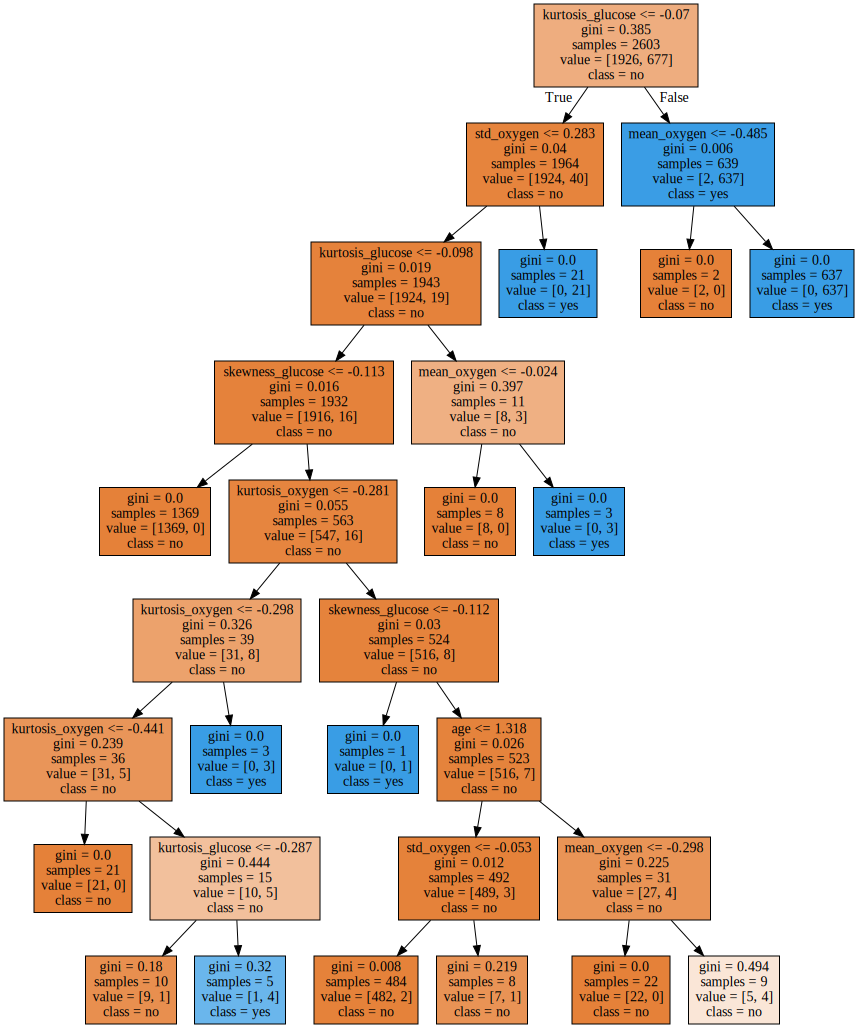

In [29]:
testDecissionTree('gini', 8, 1, None, None, np.random, 'best', X_train, y_train)

---------------------PARAMETERS---------------------
DecisionTreeClassifier(criterion='entropy', max_depth=1, splitter='random')
---------------------ACCURACY-----------------------
Accuracy:  0.9355333844973139
---------------------PRECISION----------------------
Micro-averaged precision:  0.9355333844973139
Macro-averaged precision:  0.8784879130223517
Per-class precision score: [0.99895833 0.75801749]
----------------------RECALL------------------------
Micro-averaged recall:  0.9355333844973139
Macro-averaged recall:  0.8784879130223517
Per-class recall score: [0.99895833 0.75801749]
----------------------F1-SCORE----------------------
Micro-averaged f1 score:  0.9355333844973139
Macro-averaged f1 score:  0.9094845551799193
Per-class f1 score: [0.95804196 0.86092715]


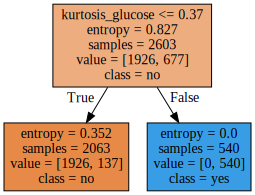

In [30]:
testDecissionTree('entropy', 1, 1, None, None, None, 'random', X_train, y_train)

---------------------PARAMETERS---------------------
DecisionTreeClassifier(criterion='entropy', max_depth=1, max_features='sqrt',
                       splitter='random')
---------------------ACCURACY-----------------------
Accuracy:  0.7367613200306984
---------------------PRECISION----------------------
Micro-averaged precision:  0.7367613200306984
Macro-averaged precision:  0.5
Per-class precision score: [1. 0.]
----------------------RECALL------------------------
Micro-averaged recall:  0.7367613200306984
Macro-averaged recall:  0.5
Per-class recall score: [1. 0.]
----------------------F1-SCORE----------------------
Micro-averaged f1 score:  0.7367613200306984
Macro-averaged f1 score:  0.42421564295183384
Per-class f1 score: [0.84843129 0.        ]


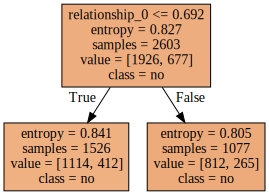

In [31]:
testDecissionTree('entropy', 1, 1, 'sqrt', None, None, 'random', X_train, y_train)

---------------------PARAMETERS---------------------
DecisionTreeClassifier(max_depth=3,
                       random_state=<module 'numpy.random' from 'C:\\Users\\makoh\\anaconda3\\envs\\IAU\\lib\\site-packages\\numpy\\random\\__init__.py'>)
---------------------ACCURACY-----------------------
Accuracy:  0.8818112049117421
---------------------PRECISION----------------------
Micro-averaged precision:  0.8818112049117421
Macro-averaged precision:  0.8954324586977649
Per-class precision score: [0.86666667 0.92419825]
----------------------RECALL------------------------
Micro-averaged recall:  0.8818112049117421
Macro-averaged recall:  0.8954324586977649
Per-class recall score: [0.86666667 0.92419825]
----------------------F1-SCORE----------------------
Micro-averaged f1 score:  0.8818112049117421
Macro-averaged f1 score:  0.8599300285358487
Per-class f1 score: [0.91529153 0.80456853]


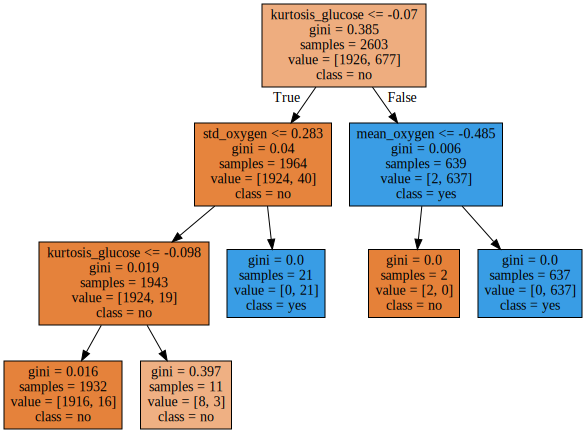

In [32]:
testDecissionTree('gini', 3, 1, None, None, np.random, 'best', X_train, y_train)

In [44]:
!pip install graphviz

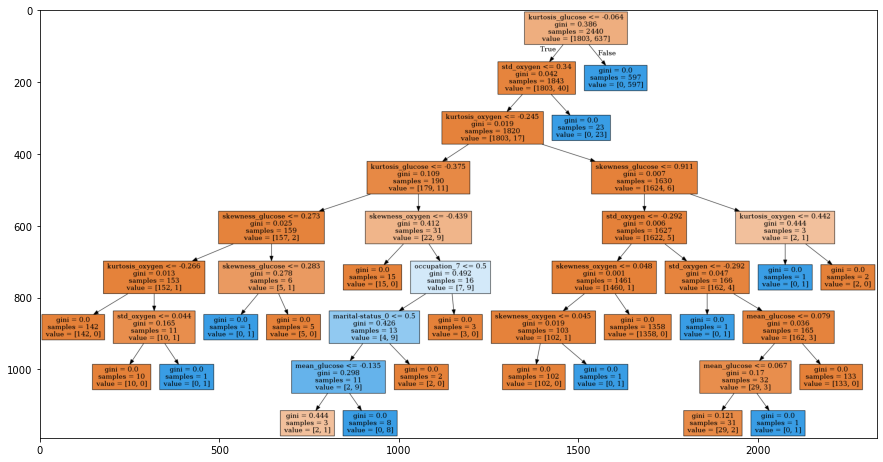

In [57]:
image = plt.imread('tree.png')
plt.figure(figsize = (15,15))
plt.imshow(image)

# Optimalizacia hyperparametrov

In [29]:
df1 = pd.read_csv("./data/personal_train.csv", index_col=0)
df2 = pd.read_csv("./data/other_train.csv", index_col=0)

print("Dlzka personal_train", df1.shape[0])
print("Pocet unique pacientov", df1["name"].nunique())
print("Rozdiel medzi velkostou df a poctu pacientov", df1.shape[0] - df1["name"].nunique())
print()

print("Dlzka other_train", df2.shape[0])
print("Pocet unique pacientov", df2["name"].nunique())
print("Rozdiel medzi velkostou df a poctu pacientov", df2.shape[0] - df2["name"].nunique())
print()

X1,y1 = prep_pip.one_proper_df(df1, df2)
print("Dlzka noveho dataframu", X1.shape[0])

Dlzka personal_train 3933
Pocet unique pacientov 3933
Rozdiel medzi velkostou df a poctu pacientov 0

Dlzka other_train 3983
Pocet unique pacientov 3933
Rozdiel medzi velkostou df a poctu pacientov 50

Dlzka noveho dataframu 3933


C:\Users\makoh\IAU\git_projekt\IAU\preprocessing_pipeline.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mini_dataset.iloc[0][attr] = not_null.values[0]


In [30]:
df1 = pd.read_csv("./data/personal_valid.csv", index_col=0)
df2 = pd.read_csv("./data/other_valid.csv", index_col=0)

print("Dlzka personal_valid", df1.shape[0])
print("Pocet unique pacientov", df1["name"].nunique())
print("Rozdiel medzi velkostou df a poctu pacientov", df1.shape[0] - df1["name"].nunique())
print()

print("Dlzka other_valid", df2.shape[0])
print("Pocet unique pacientov", df2["name"].nunique())
print("Rozdiel medzi velkostou df a poctu pacientov", df2.shape[0] - df2["name"].nunique())
print()

X2,y2 = prep_pip.one_proper_df(df1, df2)
print("Dlzka noveho dataframu", X2.shape[0])

Dlzka personal_valid 1311
Pocet unique pacientov 1311
Rozdiel medzi velkostou df a poctu pacientov 0

Dlzka other_valid 1361
Pocet unique pacientov 1311
Rozdiel medzi velkostou df a poctu pacientov 50

Dlzka noveho dataframu 1311


In [31]:
X1["class"] = y1
X2["class"] = y2

In [32]:
data = pd.concat([X1,X2])
data.shape

(5244, 25)

Je potrebne vymazat z datasetu vsetky data, kde target atribut - class je NaN

In [33]:
data = data.reset_index(drop=True)
indices = data.loc[data["class"].isnull()].index.values

data = data.drop(index=indices)
data = data.reset_index(drop=True)

data.shape

(5227, 25)

Aby sme vedeli deklarovat pipeline tak si pridame toto. Je potrebne tam dat nejaky krok, ktory hned vymazeme

Pridame kroky z preprocesingu

In [34]:
prep_steps = prep_pip.get_preprocessing_steps()

pip = imblearn.pipeline.Pipeline(steps=[
    step for step in prep_steps
])
    
from sklearn import tree
pip.steps.append(
    ("classifier", tree.DecisionTreeClassifier())
)

Tu sa specialne volaju parametre, kedze sa nachadzaju v pipeline...

In [35]:
param_grid = {
    "classifier__criterion" : ["gini", "entropy"],
    "classifier__max_depth" :  [3,5,10]
}

In [36]:
grid_search = model_selection.GridSearchCV(pip, param_grid, scoring="f1_weighted", cv=10, verbose=1, refit=False)

In [37]:
X = data.drop(columns=["class"])
y = data["class"]

grid_search.fit(X,y)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:  3.0min finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('feature_removal',
                                        FunctionTransformer(func=<function remove_useless_features at 0x000001F0CE07DB88>)),
                                       ('add_oxygen_attr',
                                        FunctionTransformer(func=<function add_oxygen_features at 0x000001F0CE07DC18>)),
                                       ('mean_glucose_to_num',
                                        FunctionTransformer(func=<function repair_mean_glucose at 0x000001F0CE07DEE8>)),
                                       ('string_...
                                                                                 'occupation_1',
                                                                                 'occupation_2',
                                                                                 'occupation_3',
                                                                                 'occupat

Vysledky

In [38]:
grid_search.cv_results_

{'mean_fit_time': array([2.55036476, 2.41426966, 2.67699916, 2.75034671, 2.84969709,
        2.72899179]),
 'std_fit_time': array([0.39447856, 0.09965912, 0.10484511, 0.1907607 , 0.28833874,
        0.0742453 ]),
 'mean_score_time': array([0.26676252, 0.25530591, 0.27875311, 0.32730372, 0.33930461,
        0.28869197]),
 'std_score_time': array([0.03439938, 0.02845357, 0.03014426, 0.08601063, 0.0444751 ,
        0.03889557]),
 'param_classifier__criterion': masked_array(data=['gini', 'gini', 'gini', 'entropy', 'entropy',
                    'entropy'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_classifier__max_depth': masked_array(data=[3, 5, 10, 3, 5, 10],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'classifier__criterion': 'gini', 'classifier__max_depth': 3},
  {'classifier__criterion': 'gini', 'classifier__max_depth': 5},

In [39]:
grid_search.best_score_

0.8928874331410407

In [40]:
grid_search.best_params_

{'classifier__criterion': 'entropy', 'classifier__max_depth': 3}

# Vyhodnotenie vplyvu zvolenej strategie riesenia na spravnost klasifikacie